https://www.kaggle.com/c/pneumonia-sai3

In [21]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torchvision
from sklearn.model_selection import train_test_split
import pandas as pd

#### Download dataset

In [22]:
# download from google drive
!pip install --upgrade gdown
!gdown --id '1K7gVVGhxJNLBRoUV9XgGn9gai6GkpTeP' --output pneumonia-kaggle.zip
# unzip dataset file
!unzip -q pneumonia-kaggle.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1K7gVVGhxJNLBRoUV9XgGn9gai6GkpTeP
From (redirected): https://drive.google.com/uc?id=1K7gVVGhxJNLBRoUV9XgGn9gai6GkpTeP&confirm=t&uuid=7e8e6800-6313-47d7-a160-9445c1c40f87
To: /content/pneumonia-kaggle.zip
100% 1.22G/1.22G [00:18<00:00, 66.9MB/s]
replace pneumonia-kaggle/test/00000.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#### Prepare dataset


In [23]:
IMG_SIZE = 256
BATCH_SIZE = 64

In [24]:
# read all paths
img_paths_all = glob('pneumonia-kaggle/train/*/*.jpeg')
img_paths_test = sorted(glob('pneumonia-kaggle/test/*.jpeg'))
img_paths_train, img_paths_val = train_test_split(
    img_paths_all,
    test_size=0.2
)

In [25]:
# number of images
len(img_paths_train), len(img_paths_val), len(img_paths_test)

(4172, 1044, 624)

pneumonia-kaggle/train/NORMAL/NORMAL2-IM-0585-0001.jpeg (256, 256)


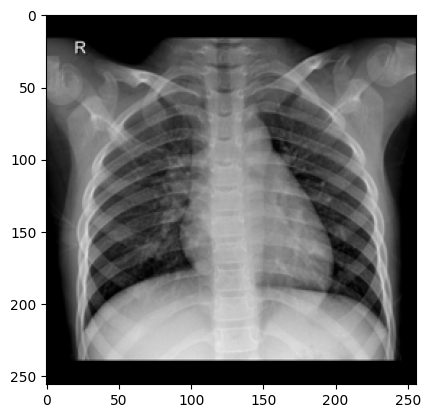

In [26]:
# show image
path = img_paths_train[0]
img = Image.open(path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
print(path, img.size)
plt.imshow(img)

In [27]:
# Extract img class
img_path = img_paths_train[0]
print(img_path)
# read label
folder = img_path.split(os.sep)[-2]
print(folder)

if folder == 'NORMAL':
    label = 0
else:
    label = 1

label

pneumonia-kaggle/train/NORMAL/NORMAL2-IM-0585-0001.jpeg
NORMAL


0

Dataset, Dataloader

In [28]:
class PneumoniaDataset(torch.utils.data.Dataset):
    def __init__(self, paths, transform):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(path).convert("RGB")
        img = self.transform(img)

        # read label
        folder = path.split(os.sep)[-2]
        label = 0 if folder == 'NORMAL' else 1
        label = torch.tensor(label, dtype=torch.long)

        return img, label

In [29]:
# ViT_L_16
transforms = torchvision.models.ViT_B_16_Weights.DEFAULT.transforms()

train_ds = PneumoniaDataset(img_paths_train, transforms)
val_ds = PneumoniaDataset(img_paths_val, transforms)

torch.Size([3, 224, 224]) tensor(1)


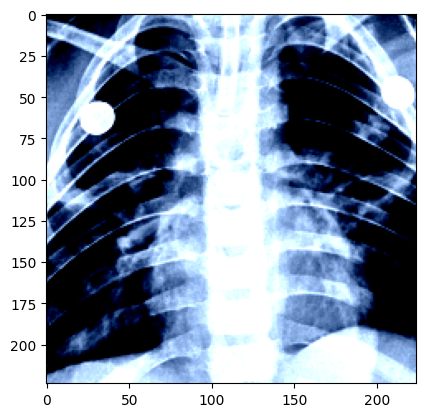

In [30]:
img, label = train_ds[2]
print(img.shape, label)
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [35]:
BS = 16
train_loader = torch.utils.data.DataLoader(train_ds, BS, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, BS)

#### Build model

In [37]:
model = torchvision.models.vit_b_16(
    weights=torchvision.models.ViT_B_16_Weights.DEFAULT
)
print(model.heads)

model.heads.head = nn.Linear(in_features=768, out_features=2)

inputs = torch.randn(1, 3, 224, 224)
outputs = model(inputs)
outputs.shape

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)


torch.Size([1, 2])

#### Training

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [39]:
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
)

In [40]:
from sklearn.metrics import (
    roc_curve,
    auc,
)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    y_preds = []
    y_trues = []
    for x, y in tqdm(dataloader, leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

        pred_probs = nn.functional.softmax(pred, dim=1) # apply softmax to logits
        y_preds.append(pred_probs[:, 1]) # target class : 1
        y_trues.append(y)

    # Compute AUROC
    y_preds = torch.cat(y_preds).detach().cpu()
    y_trues = torch.cat(y_trues).detach().cpu()
    fp_rate, tp_rate, threshold = roc_curve(
        y_trues, y_preds
    )
    auc_score = auc(fp_rate, tp_rate)

    return epoch_loss/num_batches, epoch_correct/size, auc_score


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0
    y_preds = []
    y_trues = []
    # No gradient for test data
    with torch.no_grad():
        for x, y in tqdm(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

            pred_probs = nn.functional.softmax(pred, dim=1) # apply softmax to logits
            y_preds.append(pred_probs[:, 1]) # target class : 1
            y_trues.append(y)
    # Compute AUROC
    y_preds = torch.cat(y_preds).detach().cpu()
    y_trues = torch.cat(y_trues).detach().cpu()
    fp_rate, tp_rate, threshold = roc_curve(
        y_trues, y_preds
    )
    auc_score = auc(fp_rate, tp_rate)
    return epoch_loss/num_batches, epoch_correct/size, auc_score

EPOCHS = 100
logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [],
    'train_auc': [], 'val_auc': []
}
# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc, train_auc = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc, val_auc = test(val_loader, model, loss_fn)

    print(f'EPOCH: {epoch:04d} \
    train_loss: {train_loss:.4f} val_loss: {val_loss:.4f} \
    train_auc: {train_auc:.3f}, val_auc: {val_auc:3f}')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['train_auc'].append(train_auc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)
    logs['val_auc'].append(val_auc)


    torch.save(model.state_dict(), "last.pth")
    # chcek improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0000     train_loss: 0.1728 val_loss: 0.0563     train_auc: 0.976, val_auc: 0.997566


  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0001     train_loss: 0.0934 val_loss: 0.0797     train_auc: 0.993, val_auc: 0.995995


  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0002     train_loss: 0.0642 val_loss: 0.1409     train_auc: 0.997, val_auc: 0.996218


  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0003     train_loss: 0.0531 val_loss: 0.0784     train_auc: 0.998, val_auc: 0.994959


  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0004     train_loss: 0.0526 val_loss: 0.0592     train_auc: 0.998, val_auc: 0.996981


  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

EPOCH: 0005     train_loss: 0.0434 val_loss: 0.1253     train_auc: 0.998, val_auc: 0.997685
Earlystop!


#### Make Kaggle Submission

https://www.kaggle.com/c/pneumonia-sai3

In [44]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, paths, transform):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(path).convert("RGB")
        img = self.transform(img)
        return img

test_paths = sorted(glob('pneumonia-kaggle/test/*.jpeg'))
test_ds = TestDataset(test_paths, transforms)
test_loader = torch.utils.data.DataLoader(test_ds, BS)

In [45]:
model.load_state_dict(torch.load('best.pth'))
_ = model.eval().to(device)

In [46]:
# Inference
y_pred = []
with torch.no_grad():
    for x in tqdm(test_loader):
        x = x.to(device)
        pred = model(x)
        pred_prob = nn.functional.softmax(pred, dim=1)
        y_pred.append(pred_prob[:, 1])

y_pred = torch.cat(y_pred, dim=0).cpu().numpy()

  0%|          | 0/39 [00:00<?, ?it/s]

In [47]:
df = pd.DataFrame()
df['Id'] = [f'{i:05d}.jpeg' for i in range(len(img_paths_test))]
df['Category'] = y_pred
df.to_csv('submission.csv', index=None)
df

,Id,Category
0,00000.jpeg,0.485818
1,00001.jpeg,0.997023
2,00002.jpeg,0.999432
3,00003.jpeg,0.999519
4,00004.jpeg,0.999559
...,...,...
619,00619.jpeg,0.993322
620,00620.jpeg,0.999618
621,00621.jpeg,0.065423
622,00622.jpeg,0.999570
